<a href="https://colab.research.google.com/github/samyzaf/kerutils/blob/master/opens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **VLSI Circuit Open Defects Detection Project**

* In this notebook we outline a university or college level
  challenge (in a proper deep learning course) in the area
  of VLSI defects detection.
* We also supply a large database of 400,000 syntethic circuits
  to be used for this project.

<img
src="https://samyzaf.com/ML/opens/images/cover4.png"
width=600
/>

* **Open defects** in **VLSI** integrated circuit
  production processes are known to be a common issue in
  final stages of chip production.
* They are usually sought after in the **Post Silicon**
  manufacturing stages or when defective
  chips are returned by customers.
* Soon after the first wafers come out from the fabrication
  factories, special test teams are
  hunting for circuit opens with the aid of highly expensive
  tester and prober equipments which include high resolution
  microscopes and cameras that can quickly scan large areas
  of the chip and produce high quality photos of suspected areas of the chip.

* Through the years, VLSI research and development
  centers introduced advanced methods to process and
  analyze these photos in order to find defects such
  as opens or shorts.
* No doubt that after entering the age of deep learning,
  there ought to be attempts to attack this problem from
  the deep learning point of view,
  which has already proved to be very successful in
  computer vision.

* As this tutorial is intended for a non-expert audience whose
  main interest is focusing on deep learning with neural
  networks, we will use a simplistic view of the subject
  so that we are not distracted from our main interest on
  showing how deep learning can be applied in the VLSI
  domain as well as in other domains such as computer vision,
  natural language processing and so on.


## **The circuit opens dataset**

<img
src="https://samyzaf.com/ML/opens/images/opens_1.png"
width=800
/>

We have generated a simplistic dataset of small defective circuits (due to an open).
Each circuit is drawn on a small 48x48 pixels black/white image, and is supposed
to contain at least one open defect.
The dataset is divided to 5 HDF5 files, each containing 100,000 images.
So we have a total of 500,000 images of defective circuits.
We hope they are sufficient for training a neural network to do the job
(but we must keep a small portion for validation too).

These files can be downloaded from:
1. http://www.samyzaf.com/ML/opens/opens1.h5.zip
2. http://www.samyzaf.com/ML/opens/opens2.h5.zip
3. http://www.samyzaf.com/ML/opens/opens3.h5.zip
4. http://www.samyzaf.com/ML/opens/opens4.h5.zip
5. http://www.samyzaf.com/ML/opens/opens5.h5.zip

For each circuit i, there are 3 entries associated in the dataset:
    * img_i - A Numpy matrix for the image itself
    * open_i - The open defect rectangular area
    * center_i - an (x,y) coordinates of the defect center

## **Agenda**
* Our aim in this course unit is to suggest a project proposal
  for applying deep learning methods to VLSI defects detection,
  based on our simple dataset as a simple example on how to do it.
* As a student, your goal is to define a deep convolutional
  neural network that accept a circuit image as input and finds
  the the precise location in which the circuit is open.

## Installing and loading our **kerutils** package.
* We recommend using our **kerutils** package for this project
  but expert users are oncouraged to use the **PyTorch** env.
* This package can be installed or downloaded from  
https://samyzaf.com/kerutils-1.zip


In [10]:
%pip install -q https://samyzaf.com/kerutils-1.zip
from kerutils import *
%matplotlib inline

  Preparing metadata (setup.py) ... done


## Feature Information
* We suggest that a **circuit open defect** should be coded by
  a pair of integers which is the coordinate of its center point.
* This is only a simple suggestion. You may offer a better one
  if you like. So the **features** list is the list of all
  points **(i,j)** in a 48x48 pixels
  image space of our circuit.

In [11]:
features = [(i,j) for i in range(48) for j in range(48)]

* Here is a simple diagram which explains this idea  

<img
src="https://samyzaf.com/ML/opens/images/circ35.png"
width=500
align="CENTER"
/>  

* Note the Numpy coordinate convention:
  the first coordinate **i** designates the row number,
  the second coordinate **j** designates the column number.
* This is also the standard convention in linear algebra
  matrix notation.

* So in total we will have 48x48 features (i.e., 2304 features),
  which might be too challenging for the training phase.
* The neural network output layer should have 2304 output neurons,
  which is a bit discouraging.
* You may want to refine the list of features by a simple list
  of regions in which the defect occurs.
* Once we know the region, it will be easy to locate the defect.
* Here is an example in which our 48x48 image is divided
  to 64 6x6 regions

<img
src="https://samyzaf.com/ML/opens/images/grid.png"
width=300
/>

* With this scheme, our neural network will have
  only 64 output neurons, which is not too bad.
* If you choose to work with this scheme,
  you will have to convert each defect point
  in our dataset to the corresponding region
  number in the training phase.
* It shouldn't be hard to find a simple formula for doing it.
  But again, feel free to explore other schemes (you may be
  forced to do so in case that your training dataset
  is insufficient for hitting precise locations of defects,
  so you might need to resort to coarser subdivisions)

In [12]:
# If you stick to the full 48x48 features scheme, then you will have 2304 classes
# Here is a simple way you can map pairs (i,j) to integers
classes = [48*i+j for i in range(48) for j in range(48)]

# This is a very long list, so we print the first 100 elements only:
print(classes[0:100])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


## Data Exploration

* Lets explore our **HDF5** files to help you get started with
  your deep learning project.

* We first show how to parse an **HDF5** in order to extract
  the image and other circuit data.

In [13]:
# This is how you open an HDF5 file in the context of kerutils package
url = "https://samyzaf.com/ML/opens/opens1.h5.zip"
f = h5open(url)

# We will collect 2000 images (from the 80,000 images in this file) in one long Python list
images = []

# We will collect the first 2000 boxes
boxes = []

# And finally we will also collect the first 2000 defect centers
centers = []

# Our HDF5 file has a special key for the number of images which we're not going to use here
# but you will need it for the full project
# num_images = f.get('num_images').value

for i in range(2000):
    box_key = 'open_' + str(i)
    img_key = 'img_' + str(i)
    center_key = 'center_' + str(i)

    # This is the shape of the open defect
    box = np.array(f.get(box_key))
    boxes.append(box)

    # This is image i
    img = np.array(f.get(img_key))
    images.append(img)

    # This is the defect center data
    c = np.array(f.get(center_key))
    centers.append(c)

# Do not forget to close the HDF5 file!
f.close()

Downloaded opens1.h5.zip from https://samyzaf.com/ML/opens/opens1.h5.zip


* Here is a simplistic matplotlib procedure for drawing a circuit.

In [24]:
plt.rcParams['figure.figsize'] = 5,5

def draw_circ(i):
    print("Image id:", i)
    #print("Features:", hands[i])
    #c = box[i]
    img = images[i]
    x, y = centers[i]
    box = boxes[i]
    print("Box: %s" % (box,))
    print("Center: (%d,%d)" % (x,y))
    plt.title("circ%d: open=(%d,%d)" % (i,x,y), fontsize=18, fontweight='bold', y=1.02)
    ticks=[0,8,16,24,32,40, 48]
    plt.xticks(ticks, fontsize=12)
    plt.yticks(ticks, fontsize=12)
    plt.imshow(img, cmap='gray', interpolation='none')
    plt.plot(y, x, 'or')
    plt.grid()

* Let's draw a few samples of circuits.

Image id: 35
Box: [27 29 15 17]
Center: (28,16)


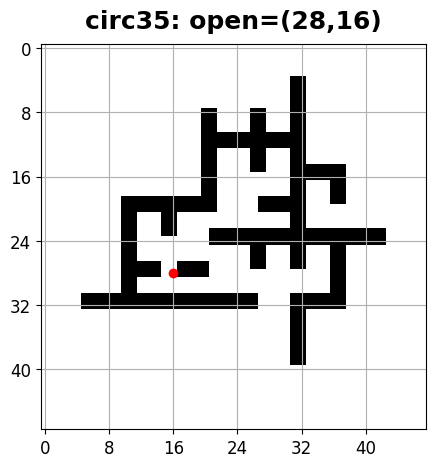

In [25]:
draw_circ(35)

Image id: 476
Box: [ 9 11 20 22]
Center: (10,21)


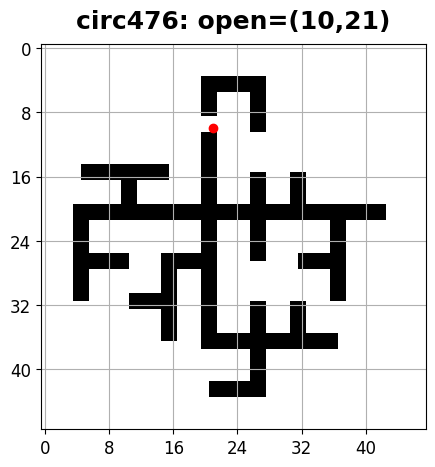

In [26]:
draw_circ(476)

* In some cases we need to view a larger group of samples
  at the same time.
* For example if we have a large group of false predictions,
  it is useful to look at a dozen or two of them in order
  to get a feeling about the kind of failure.
* The following function we draw a grid of $m{\times}n$ of circuits,
  $m$ rows, $n$ columns:

In [28]:
plt.rcParams['figure.figsize'] = 10,10
def draw_group(imgs, cntrs, rows=4, cols=4):
    for i in range(0, rows*cols):
        ax = plt.subplot(rows, cols, i+1)
        img = imgs[i]
        x, y = cntrs[i]
        plt.title("circ%d: open=(%d,%d)" % (i,x,y), fontsize=8, fontweight='bold', y=1.02)
        ticks=[0,8,16,24,32,40, 48]
        plt.xticks(ticks, fontsize=7)
        plt.yticks(ticks, fontsize=7)
        plt.imshow(img, cmap='gray', interpolation='none')
        # adding a red marker for highlighting the open
        plt.plot(y, x, '.r', linewidth=0)
        plt.subplots_adjust(wspace=0.5, hspace=0.1)

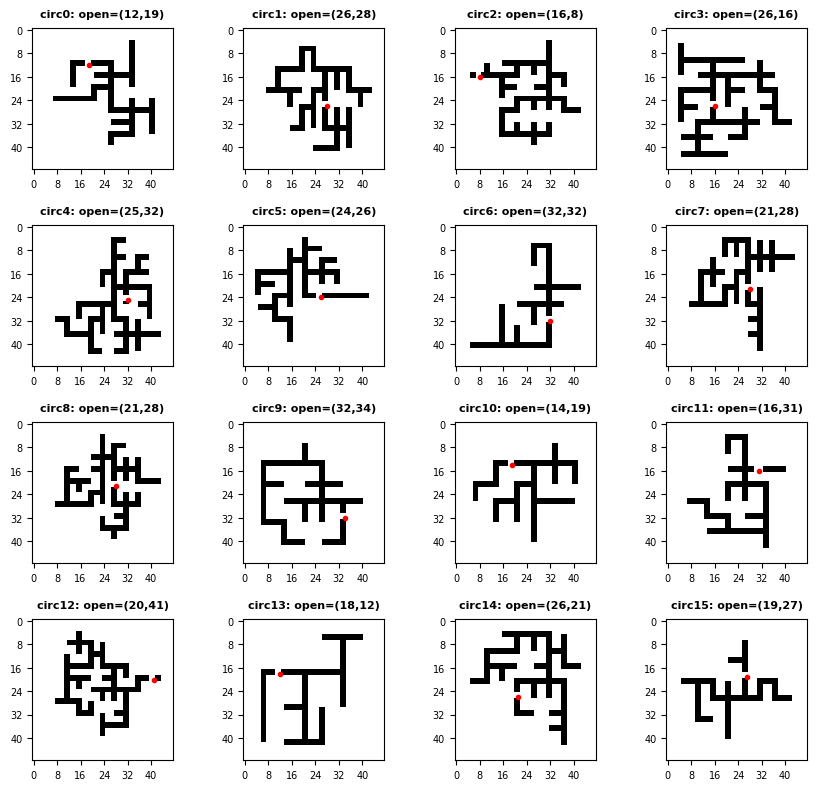

In [30]:
draw_group(images[100:124], centers[100:124])

## Class distribution (or class imbalance)

* It is also highly recommended that you calculate the
  class distribution of your data.
* Try to count how many samples belong to each class.
* Like how many samples have an open defect at the
  point (32,15) (or in the region 17, if you go for
  the regions scheme)?
* This is important to do in order to tune your expectations
  for model accuracy.
* The more the imbalance, the more chances that your model
  will be less accurate and biased.
* Therefore, you may need to carefully pick your training
  dataset from the above 400,000 samples.
* This task is of course part of this project ...

## **Your Mission**

1. Build your training and validation sets
  (from the above 400,000 samples). Deciding on a
  features scheme, your mission is to build a convolutional
  neural network for detecting the opens.
2. Make sure you don't use too many paramaters.
   Try to stay below half million.
3. Make sure you don't use too many layers. Try not to go beyond 12.
4. Make sure your model is trainable in a reasonable time.
   An upper bound of 10 to 20 hours is reasonable.
   Anythong beyond two days is unreasonable.
   This is assuming you are using a decent GPU card
   (or a good computing cloud service).
   Otherwise don't try it on your CPU (it can take forever).
5. Analyze the cases in which your model makes a false prediction.